<a href="https://colab.research.google.com/github/stelios191/Image-Classification/blob/main/CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Deep network for image classification

#DATASET: CIFAR10

**Check for GPU.**

In [ ]:
!nvidia-smi

Mon Apr 29 20:26:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   36C    P8              11W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**1.Download packages**

In [ ]:
!pip install torch torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

**2. Libraries**

In [ ]:
from torchvision.datasets import CIFAR10
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import os
from torchsummary import summary
from torchvision.models import googlenet

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

**3.Dataset**

In [ ]:
""" Code From CW1 TRANSFORMERS"""
train_data = CIFAR10(root='.', train=True, download=True, transform=
transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),]))
test_data= CIFAR10(root='.', train=False, download=True, transform=transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),]))

100%|██████████| 170498071/170498071 [00:04<00:00, 37230293.39it/s]


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


**3.1 Dataset loader**

In [ ]:
def data_loaders(train_data,test_data,batch_size):
    #Create data loaders with dynamic batch size
    train_loader =DataLoader(train_data,batch_size=batch_size,shuffle=True)
    test_loader =DataLoader(test_data,batch_size=batch_size,shuffle=False)
    print(f"train_loader length:{len(train_loader)}")
    print(f"test_loader length:{len(test_loader)}")
    return train_loader,test_loader

**4.Context for Data**

In [ ]:
image,label =train_data[0]
names =train_data.class_to_idx
print(f"Image size :{image.shape}")
print(f"Class names:{names}")
print(f"Train data length:{len(train_data.data)}")
print(f"Test data length:{len(test_data.data)}")

Image size :torch.Size([3, 32, 32])
Class names:{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
Train data length:50000
Test data length:10000


#Helper Functions

In [ ]:
def compute_accuracy(true_labels,predicted_labels):
    #Compute the accuracy of predictions
    correct_predictions =torch.eq(true_labels,predicted_labels).sum().item()
    accuracy =(correct_predictions / len(true_labels)) * 100
    return accuracy

def train_and_test(model,train_loader,test_loader,criterion,optimizer,device,num_epochs:int):
    model.to(device)
    train_accuracies =[]
    train_losses =[]
    test_accuracies =[]
    test_losses =[]
    training_time =0
    for epoch in range(num_epochs):
        #Start time for the epoch
        start_time =time.time()
        #Training
        model.train()
        train_loss,train_accuracy =0, 0
        for inputs,targets in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
            inputs,targets =inputs.to(device),targets.to(device)
            optimizer.zero_grad()
            outputs =model(inputs)
            loss =criterion(outputs,targets)
            loss.backward()
            optimizer.step()
            train_loss +=loss.item() * inputs.size(0)
            train_accuracy +=compute_accuracy(targets, outputs.argmax(dim=1))
        epoch_train_loss =train_loss / len(train_loader.dataset)
        epoch_train_accuracy =train_accuracy / len(train_loader)
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)
        # Testing
        model.eval()
        test_loss, test_accuracy =0, 0
        with torch.no_grad():
            for inputs,targets in tqdm(test_loader,desc="Testing"):
                inputs,targets =inputs.to(device),targets.to(device)
                outputs =model(inputs)
                loss =criterion(outputs, targets)
                test_loss +=loss.item() * inputs.size(0)
                test_accuracy +=compute_accuracy(targets, outputs.argmax(dim=1))
        epoch_test_loss =test_loss / len(test_loader.dataset)
        epoch_test_accuracy =test_accuracy / len(test_loader)
        test_losses.append(epoch_test_loss)
        test_accuracies.append(epoch_test_accuracy)
        # Timing and printing
        epoch_duration =time.time() - start_time
        training_time +=epoch_duration
        print(f'Epoch {epoch+1}: Train Loss:{epoch_train_loss:.4f},Train Accuracy:{epoch_train_accuracy:.2f}%, '
              f'Test Loss:{epoch_test_loss:.4f},Test Accuracy:{epoch_test_accuracy:.2f}%, '
              f'Duration:{epoch_duration:.2f}s')
    print(f"Total training time:{training_time:.2f}s")
    return train_accuracies,train_losses,test_accuracies,test_losses,training_time

def plot_loss(train_losses,test_losses):
    #Plot training and testing losses over epochs
    plt.figure(figsize=(10,6))
    epochs = range(1,len(train_losses) + 1)
    plt.plot(epochs,train_losses,'o-',label='Train Loss')
    plt.plot(epochs,test_losses,'o-',label='Test Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_accuracy(train_accuracies,test_accuracies):
    #Plot training and testing accuracies over epochs
    plt.figure(figsize=(10, 6))
    epochs = range(1,len(train_accuracies) + 1)
    plt.plot(epochs,train_accuracies, 'o-',label='Train Accuracy')
    plt.plot(epochs,test_accuracies,'o-',label='Test Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

def visualise_predictions(model,test_loader,device,num_images: int):
    model.eval()
    indices =torch.randperm(len(test_loader.dataset))[:num_images]
    sampler =SubsetRandomSampler(indices)
    random_loader= DataLoader(test_loader.dataset, batch_size=num_images, sampler=sampler)
    images,labels= next(iter(random_loader))
    images,labels =images.to(device), labels.to(device)
    outputs= model(images)
    _,preds= torch.max(outputs,1)
    nrows= int(num_images ** 0.5)
    ncols =(num_images // nrows)+(num_images % nrows > 0)
    plt.figure(figsize=(2*ncols, 2*nrows))
    # Get the class names
    class_names ={v: k for k, v in train_data.class_to_idx.items()}
    mean =torch.tensor([0.4914,0.4822,0.4465]).view(1,1,3)
    std = torch.tensor([0.2023,0.1994,0.2010]).view(1,1,3)
    for i in range(num_images):
        ax = plt.subplot(nrows,ncols,i+1)
        image =images[i].cpu()
        #Reorder to H,W,C
        image =image.permute(1,2,0)
        #Unnormalize
        image =image * std + mean
        #Ensure the image is in 0,1
        image =torch.clamp(image,0,1)
        ax.imshow(image)
        true_label =class_names[labels[i].item()]
        pred_label =class_names[preds[i].item()]
        title_text =f"True: {true_label}\nPred:{pred_label}"
        title_color ="green" if labels[i] == preds[i] else "red"
        ax.set_title(title_text,color=title_color,fontsize=10)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

#ResNet

**The model is adapted from PyTorch original implementation [link](https://pytorch.org/vision/main/_modules/torchvision/models/resnet.html#ResNet18_Weights)**

In [ ]:
class BasicBlock(nn.Module):
    expansion =1
    def __init__(self, in_channels,out_channels,stride=1):
        super(BasicBlock, self).__init__()
        #First convolutional layer
        self.conv1 =nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=stride,padding=1)
        self.bn1 =nn.BatchNorm2d(out_channels)
        #Second convolutional layer
        self.conv2 =nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=1,padding=1)
        self.bn2 =nn.BatchNorm2d(out_channels)
        self.shortcut =nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride ),
                nn.BatchNorm2d(self.expansion * out_channels))

    def forward(self,x):
        out=F.relu(self.bn1(self.conv1(x)))
        out=self.bn2(self.conv2(out))
        out +=self.shortcut(x)
        out=F.relu(out)
        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(self,block,num_blocks,num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels =64
        self.conv1=nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 =nn.BatchNorm2d(64)
        self.layer1 =self._make_layer(block,64,num_blocks[0],stride=1)
        self.layer2 =self._make_layer(block,128,num_blocks[1],stride=2)
        self.layer3 =self._make_layer(block,256,num_blocks[2],stride=2)
        self.layer4 =self._make_layer(block,512,num_blocks[3],stride=2)
        self.linear =nn.Linear(512 * block.expansion,num_classes)

    def _make_layer(self,block,out_channels,num_blocks,stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels,stride))
            self.in_channels= out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self,x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.adaptive_avg_pool2d(out,(1,1))
        out = out.view(out.size(0),-1)
        out = self.linear(out)
        return out

In [ ]:
ResNet_model =ResNet(BasicBlock,[2,2,2,2],num_classes=10).to(device)
criterion =nn.CrossEntropyLoss()
optimizer =optim.SGD(ResNet_model.parameters(),lr=0.001,momentum=0.9)
batch_size =32
train_loader,test_loader =data_loaders(train_data,test_data,batch_size)

train_loader length:1563
test_loader length:313


In [ ]:
print(ResNet_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut)

In [ ]:
x=torch.randn(10,3,32,32).to(device)
try:
    output =ResNet_model(x)
    print("Output shape:",output.shape)
except Exception as e:
    print("Error:",e)

Output shape: torch.Size([10, 10])


In [ ]:
summary(ResNet_model,input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,928
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,928
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,928
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,928
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,856
      BatchNorm2d-14          [-1, 128,

**Train the Model**

Testing: 100%|██████████| 313/313 [00:03<00:00, 86.91it/s]


Epoch 1: Train Loss:1.4203,Train Accuracy:47.99%, Test Loss:1.1835,Test Accuracy:58.68%, Duration:44.17s


Testing: 100%|██████████| 313/313 [00:03<00:00, 86.72it/s]


Epoch 2: Train Loss:0.9485,Train Accuracy:66.35%, Test Loss:0.9193,Test Accuracy:69.16%, Duration:43.67s


Testing: 100%|██████████| 313/313 [00:03<00:00, 85.55it/s]


Epoch 3: Train Loss:0.7424,Train Accuracy:73.96%, Test Loss:0.6430,Test Accuracy:77.77%, Duration:43.62s


Testing: 100%|██████████| 313/313 [00:03<00:00, 86.67it/s]


Epoch 4: Train Loss:0.6303,Train Accuracy:78.18%, Test Loss:0.5768,Test Accuracy:80.12%, Duration:43.68s


Testing: 100%|██████████| 313/313 [00:03<00:00, 85.96it/s]


Epoch 5: Train Loss:0.5556,Train Accuracy:80.78%, Test Loss:0.5459,Test Accuracy:81.72%, Duration:43.75s


Testing: 100%|██████████| 313/313 [00:03<00:00, 86.15it/s]


Epoch 6: Train Loss:0.4953,Train Accuracy:82.92%, Test Loss:0.5168,Test Accuracy:82.73%, Duration:43.65s


Testing: 100%|██████████| 313/313 [00:03<00:00, 86.04it/s]


Epoch 7: Train Loss:0.4501,Train Accuracy:84.45%, Test Loss:0.4958,Test Accuracy:83.78%, Duration:43.82s


Testing: 100%|██████████| 313/313 [00:03<00:00, 86.96it/s]


Epoch 8: Train Loss:0.4115,Train Accuracy:85.58%, Test Loss:0.4301,Test Accuracy:85.43%, Duration:43.60s


Testing: 100%|██████████| 313/313 [00:03<00:00, 86.46it/s]


Epoch 9: Train Loss:0.3850,Train Accuracy:86.73%, Test Loss:0.4173,Test Accuracy:86.13%, Duration:43.56s


Testing: 100%|██████████| 313/313 [00:03<00:00, 86.05it/s]


Epoch 10: Train Loss:0.3541,Train Accuracy:87.68%, Test Loss:0.4246,Test Accuracy:86.08%, Duration:43.66s


Testing: 100%|██████████| 313/313 [00:03<00:00, 86.45it/s]


Epoch 11: Train Loss:0.3308,Train Accuracy:88.46%, Test Loss:0.4091,Test Accuracy:86.22%, Duration:43.55s


Testing: 100%|██████████| 313/313 [00:03<00:00, 85.32it/s]


Epoch 12: Train Loss:0.3047,Train Accuracy:89.36%, Test Loss:0.4244,Test Accuracy:85.95%, Duration:43.98s


Testing: 100%|██████████| 313/313 [00:03<00:00, 85.33it/s]


Epoch 13: Train Loss:0.2941,Train Accuracy:89.88%, Test Loss:0.3653,Test Accuracy:88.05%, Duration:44.03s


Testing: 100%|██████████| 313/313 [00:03<00:00, 85.99it/s]


Epoch 14: Train Loss:0.2732,Train Accuracy:90.62%, Test Loss:0.3668,Test Accuracy:88.27%, Duration:44.06s


Testing: 100%|██████████| 313/313 [00:03<00:00, 85.41it/s]


Epoch 15: Train Loss:0.2555,Train Accuracy:91.00%, Test Loss:0.4447,Test Accuracy:86.37%, Duration:43.75s


Testing: 100%|██████████| 313/313 [00:03<00:00, 86.45it/s]


Epoch 16: Train Loss:0.2371,Train Accuracy:91.81%, Test Loss:0.3782,Test Accuracy:88.13%, Duration:43.55s


Testing: 100%|██████████| 313/313 [00:03<00:00, 87.26it/s]


Epoch 17: Train Loss:0.2302,Train Accuracy:91.84%, Test Loss:0.4110,Test Accuracy:87.39%, Duration:43.53s


Testing: 100%|██████████| 313/313 [00:03<00:00, 86.66it/s]


Epoch 18: Train Loss:0.2150,Train Accuracy:92.46%, Test Loss:0.3381,Test Accuracy:89.28%, Duration:43.75s


Testing: 100%|██████████| 313/313 [00:03<00:00, 85.21it/s]


Epoch 19: Train Loss:0.2063,Train Accuracy:92.72%, Test Loss:0.3657,Test Accuracy:88.84%, Duration:43.83s


Testing: 100%|██████████| 313/313 [00:03<00:00, 87.01it/s]


Epoch 20: Train Loss:0.1901,Train Accuracy:93.40%, Test Loss:0.3918,Test Accuracy:88.07%, Duration:43.64s
Total training time:874.85s


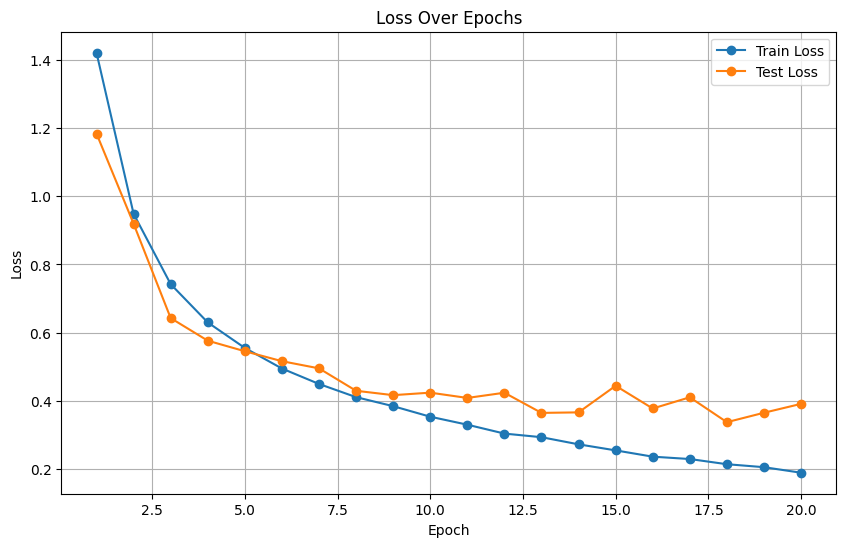

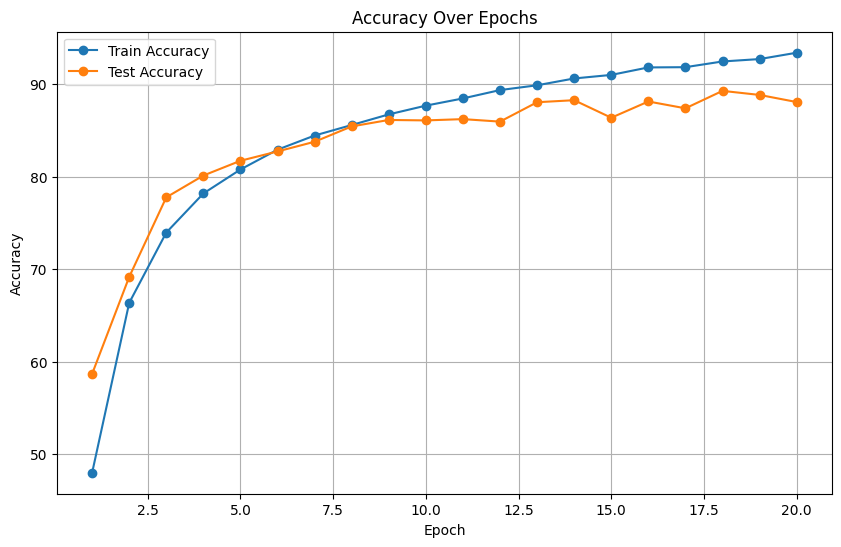

In [ ]:
train_accuracies,train_losses,test_accuracies,test_losses,total_train_time =train_and_test(ResNet_model,train_loader,test_loader,criterion,optimizer,device,num_epochs=20)
plot_loss(train_losses,test_losses)
plot_accuracy(train_accuracies,test_accuracies)

# **Evaluation**

**Visualise predictions**

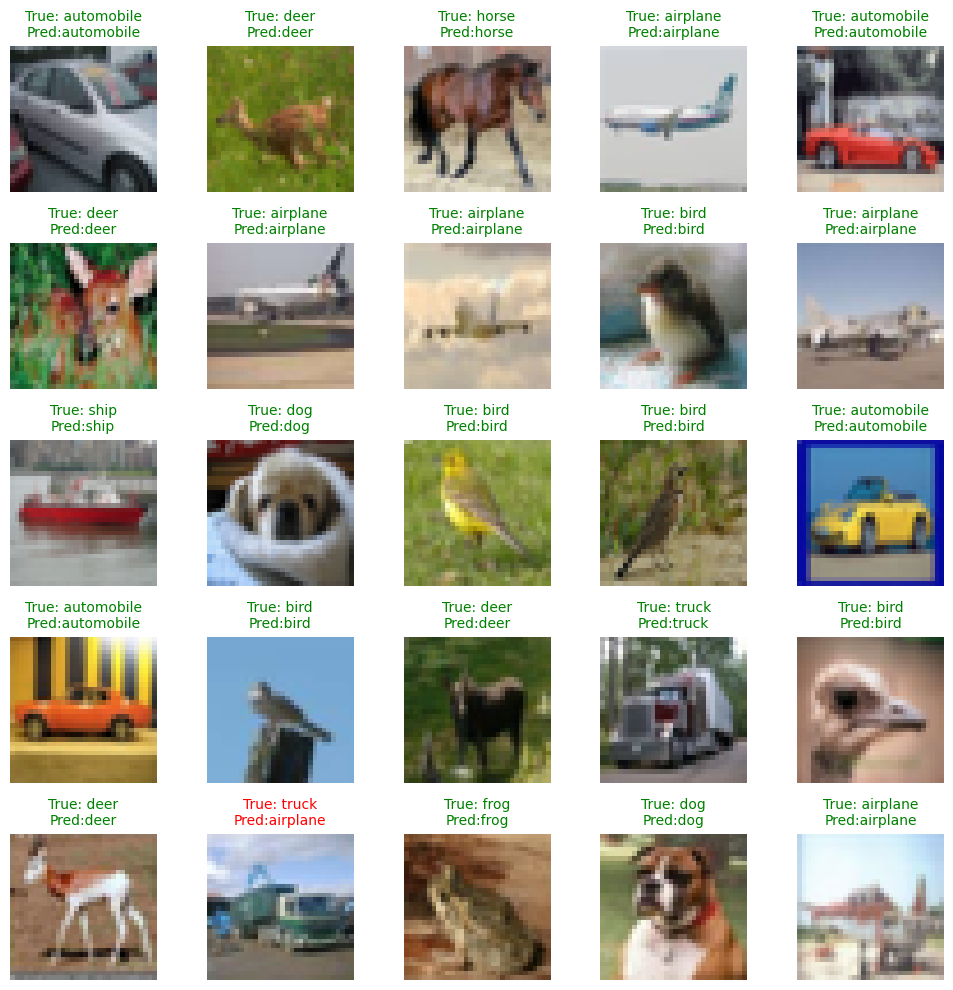

In [ ]:
visualise_predictions(ResNet_model,test_loader,device,num_images=25)

**Confusion Matrix.**

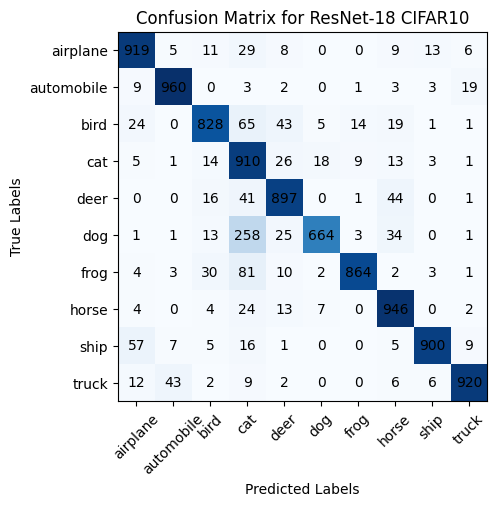

In [ ]:
ResNet_model.to(device).eval()
true_labels =[]
pred_labels =[]
#Generate predictions
with torch.no_grad():
    for images,labels in test_loader:
        images,labels =images.to(device),labels.to(device)
        outputs =ResNet_model(images)
        _,preds=torch.max(outputs,1)
        #true labels
        true_labels.extend(labels.cpu().numpy())
        #predicted labels
        pred_labels.extend(preds.cpu().numpy())
#Calculate the confusion matrix
cm =confusion_matrix(true_labels, pred_labels)
fig,ax =plt.subplots()
im =ax.imshow(cm,cmap=plt.cm.Blues)
#Labels for axes
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_xticks(np.arange(len(names)))
ax.set_yticks(np.arange(len(names)))
ax.set_xticklabels(names,rotation=45)
ax.set_yticklabels(names)
ax.set_title('Confusion Matrix for ResNet-18 CIFAR10')
#Text annotations
for (i,j), val in np.ndenumerate(cm):
    ax.text(j,i,f'{val}',ha='center',va='center',color='black')
plt.show()

**Classification Report.**

In [ ]:
names =train_data.class_to_idx
print(f"Classification Report for ResNet CIFAR10:\n"
      f"{classification_report(true_labels,pred_labels, target_names=names,digits=4)}\n")

Classification Report for ResNet CIFAR10:
              precision    recall  f1-score   support

    airplane     0.8879    0.9190    0.9032      1000
  automobile     0.9412    0.9600    0.9505      1000
        bird     0.8971    0.8280    0.8612      1000
         cat     0.6337    0.9100    0.7471      1000
        deer     0.8734    0.8970    0.8851      1000
         dog     0.9540    0.6640    0.7830      1000
        frog     0.9686    0.8640    0.9133      1000
       horse     0.8751    0.9460    0.9092      1000
        ship     0.9688    0.9000    0.9331      1000
       truck     0.9573    0.9200    0.9383      1000

    accuracy                         0.8808     10000
   macro avg     0.8957    0.8808    0.8824     10000
weighted avg     0.8957    0.8808    0.8824     10000




**Save the model**

In [ ]:
model_dir ='/content/models_CIFAR10'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    print(f"Directory 'models_CIFAR10' created at {model_dir}")
else:
    print(f"Directory 'models_CIFAR10' already exists at {model_dir}")
model_filename =f"{ResNet_model.__class__.__name__}.pth"
model_path =os.path.join(model_dir,model_filename)
torch.save(ResNet_model.state_dict(),model_path)
print(f'Model saved to {model_path}')

Directory 'models_CIFAR10' created at /content/models_CIFAR10
Model saved to /content/models_CIFAR10/ResNet.pth


#VGG-16

**The model is adapted from PyTorch original implementation [link](https://github.com/pytorch/vision/blob/main/torchvision/models/vgg.py)**

In [ ]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.features =nn.Sequential(
            nn.Conv2d(3,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128,128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            nn.Conv2d(128,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(256,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2))
        self.avgpool =nn.AdaptiveAvgPool2d((7,7))
        self.classifier =nn.Sequential(
            nn.Linear(25088,4096),nn.ReLU(inplace=True),
            nn.Linear(4096,4096),nn.ReLU(inplace=True),
            nn.Linear(4096,10))

    def forward(self,x):
        x =self.features(x)
        x =self.avgpool(x)
        x =x.view(x.size(0), -1)
        x =self.classifier(x)
        prob=F.softmax(x,dim=1)
        return x

In [ ]:
VGG_model =VGG().to(device)
batch_size =32
train_loader,test_loader= data_loaders(train_data,test_data,batch_size)
VGG_criterion =nn.CrossEntropyLoss()
VGG_optimizer =optim.SGD(VGG_model.parameters(),lr=0.001,momentum=0.9)

train_loader length:1563
test_loader length:313


In [ ]:
summary(VGG_model,input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
        MaxPool2d-14            [-1, 12

In [ ]:
try:
    output = VGG_model(x)
    print("Output shape:",output.shape)
except Exception as e:
    print("Error:",e)

Output shape: torch.Size([10, 10])


In [ ]:
print(VGG_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
summary(VGG_model,input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
        MaxPool2d-14            [-1, 12

**Train**

Testing: 100%|██████████| 313/313 [00:04<00:00, 77.91it/s]


Epoch 1: Train Loss:1.4365,Train Accuracy:47.34%, Test Loss:1.2605,Test Accuracy:55.18%, Duration:74.91s


Testing: 100%|██████████| 313/313 [00:04<00:00, 77.21it/s]


Epoch 2: Train Loss:0.9730,Train Accuracy:65.85%, Test Loss:0.8179,Test Accuracy:71.33%, Duration:74.79s


Testing: 100%|██████████| 313/313 [00:04<00:00, 77.52it/s]


Epoch 3: Train Loss:0.7767,Train Accuracy:73.41%, Test Loss:0.6994,Test Accuracy:75.89%, Duration:74.88s


Testing: 100%|██████████| 313/313 [00:04<00:00, 76.99it/s]


Epoch 4: Train Loss:0.6597,Train Accuracy:77.30%, Test Loss:0.6301,Test Accuracy:78.80%, Duration:74.81s


Testing: 100%|██████████| 313/313 [00:04<00:00, 76.16it/s]


Epoch 5: Train Loss:0.5888,Train Accuracy:79.78%, Test Loss:0.5848,Test Accuracy:80.33%, Duration:75.00s


Testing: 100%|██████████| 313/313 [00:04<00:00, 76.84it/s]


Epoch 6: Train Loss:0.5259,Train Accuracy:81.98%, Test Loss:0.5292,Test Accuracy:82.23%, Duration:74.94s


Testing: 100%|██████████| 313/313 [00:04<00:00, 77.81it/s]


Epoch 7: Train Loss:0.4828,Train Accuracy:83.49%, Test Loss:0.5167,Test Accuracy:81.94%, Duration:74.63s


Testing: 100%|██████████| 313/313 [00:04<00:00, 76.64it/s]


Epoch 8: Train Loss:0.4384,Train Accuracy:84.99%, Test Loss:0.4855,Test Accuracy:83.73%, Duration:74.74s


Testing: 100%|██████████| 313/313 [00:04<00:00, 77.15it/s]


Epoch 9: Train Loss:0.4095,Train Accuracy:85.98%, Test Loss:0.4174,Test Accuracy:85.72%, Duration:74.86s


Testing: 100%|██████████| 313/313 [00:04<00:00, 77.18it/s]


Epoch 10: Train Loss:0.3780,Train Accuracy:87.02%, Test Loss:0.4399,Test Accuracy:85.67%, Duration:74.72s


Testing: 100%|██████████| 313/313 [00:04<00:00, 77.24it/s]


Epoch 11: Train Loss:0.3546,Train Accuracy:87.74%, Test Loss:0.4062,Test Accuracy:86.32%, Duration:74.80s


Testing: 100%|██████████| 313/313 [00:04<00:00, 76.64it/s]


Epoch 12: Train Loss:0.3297,Train Accuracy:88.63%, Test Loss:0.4097,Test Accuracy:86.48%, Duration:74.85s


Testing: 100%|██████████| 313/313 [00:04<00:00, 76.96it/s]


Epoch 13: Train Loss:0.3135,Train Accuracy:89.09%, Test Loss:0.3985,Test Accuracy:86.73%, Duration:74.83s


Testing: 100%|██████████| 313/313 [00:04<00:00, 77.32it/s]


Epoch 14: Train Loss:0.2885,Train Accuracy:90.09%, Test Loss:0.3619,Test Accuracy:87.66%, Duration:74.67s


Testing: 100%|██████████| 313/313 [00:04<00:00, 76.23it/s]


Epoch 15: Train Loss:0.2783,Train Accuracy:90.32%, Test Loss:0.3916,Test Accuracy:86.73%, Duration:74.81s


Testing: 100%|██████████| 313/313 [00:04<00:00, 77.31it/s]


Epoch 16: Train Loss:0.2634,Train Accuracy:90.80%, Test Loss:0.3701,Test Accuracy:87.59%, Duration:74.85s


Testing: 100%|██████████| 313/313 [00:04<00:00, 77.59it/s]


Epoch 17: Train Loss:0.2473,Train Accuracy:91.47%, Test Loss:0.3807,Test Accuracy:87.62%, Duration:74.55s


Testing: 100%|██████████| 313/313 [00:04<00:00, 77.06it/s]


Epoch 18: Train Loss:0.2344,Train Accuracy:91.85%, Test Loss:0.3704,Test Accuracy:88.10%, Duration:74.86s


Testing: 100%|██████████| 313/313 [00:04<00:00, 76.60it/s]


Epoch 19: Train Loss:0.2231,Train Accuracy:92.27%, Test Loss:0.3891,Test Accuracy:87.67%, Duration:74.87s


Testing: 100%|██████████| 313/313 [00:04<00:00, 76.95it/s]


Epoch 20: Train Loss:0.2091,Train Accuracy:92.64%, Test Loss:0.3487,Test Accuracy:88.61%, Duration:74.78s
Total training time:1496.20s


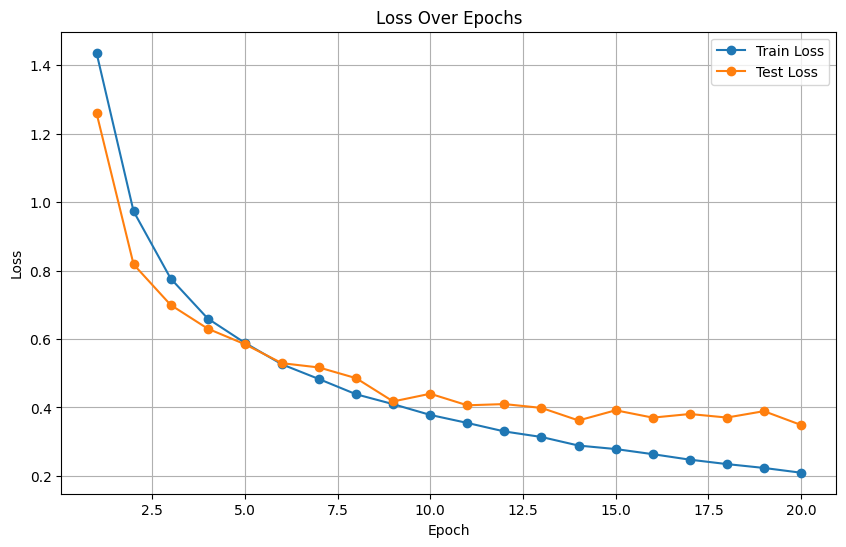

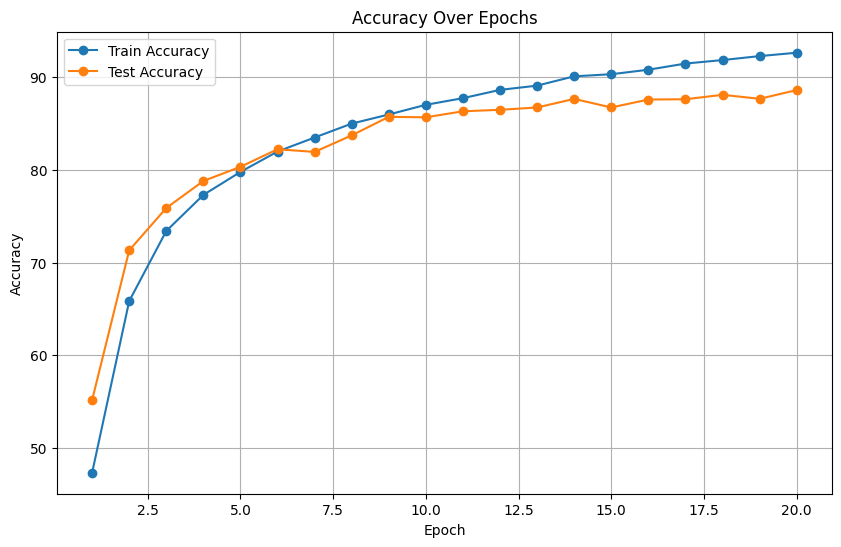

In [ ]:
VGG_train_accuracies,VGG_train_losses,VGG_test_accuracies,VGG_test_losses,VGG_total_train_time =train_and_test(VGG_model,train_loader,test_loader,VGG_criterion,VGG_optimizer,device,num_epochs=20)
plot_loss(VGG_train_losses,VGG_test_losses)
plot_accuracy(VGG_train_accuracies,VGG_test_accuracies)

#**Evaluation**

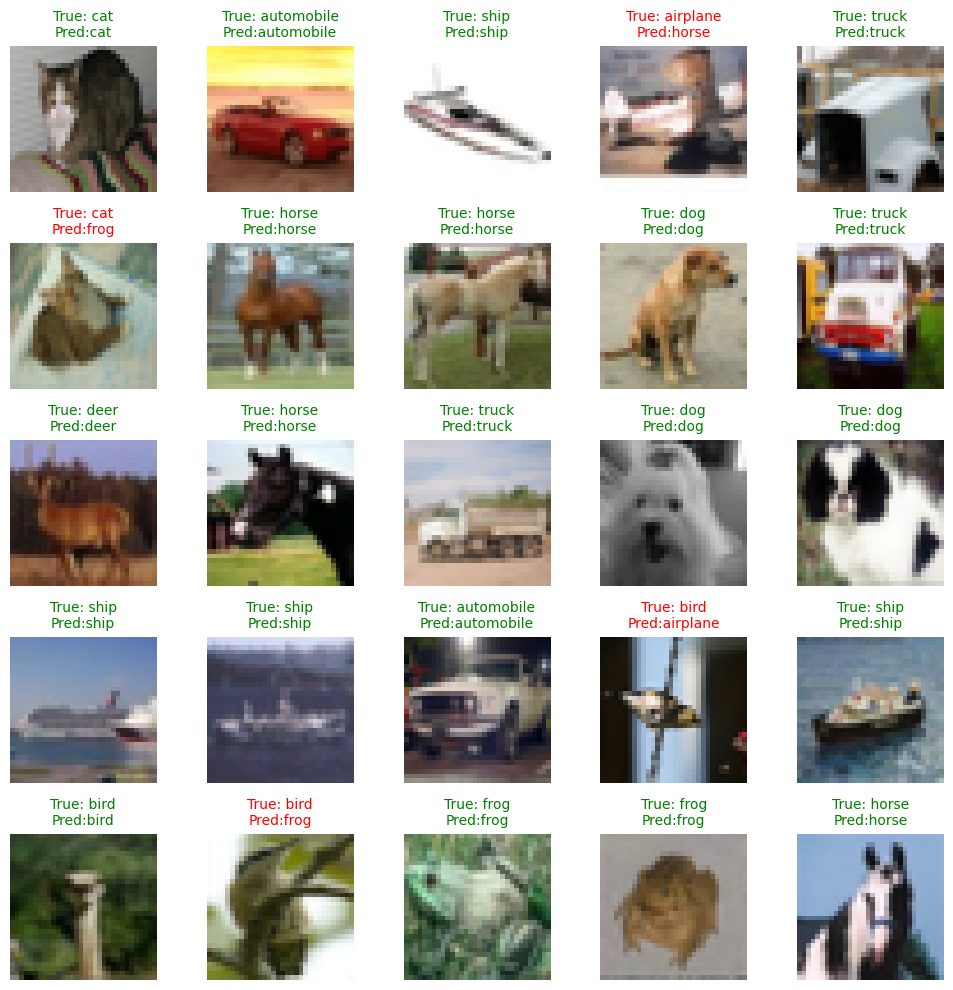

In [ ]:
visualise_predictions(VGG_model,test_loader,device,num_images=25)

**Confussion Matrix.**

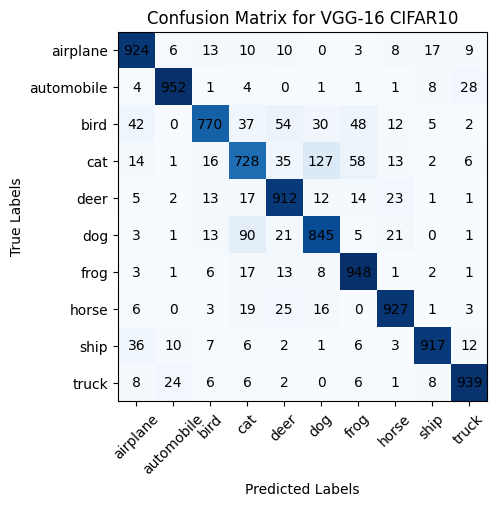

In [ ]:
VGG_model.to(device).eval()
true_labels_v =[]
pred_labels_v =[]
#Generate predictions
with torch.no_grad():
    for images,labels in test_loader:
        images,labels =images.to(device),labels.to(device)
        outputs =VGG_model(images)
        _,preds=torch.max(outputs,1)
        #true labels
        true_labels_v.extend(labels.cpu().numpy())
        #predicted labels
        pred_labels_v.extend(preds.cpu().numpy())
#Calculate the confusion matrix
cm =confusion_matrix(true_labels_v, pred_labels_v)
fig,ax =plt.subplots()
im =ax.imshow(cm,cmap=plt.cm.Blues)
#Labels for axes
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_xticks(np.arange(len(names)))
ax.set_yticks(np.arange(len(names)))
ax.set_xticklabels(names,rotation=45)
ax.set_yticklabels(names)
ax.set_title('Confusion Matrix for VGG-16 CIFAR10')
#Text annotations
for (i,j), val in np.ndenumerate(cm):
    ax.text(j,i,f'{val}',ha='center',va='center',color='black')
plt.show()

**Classification Report.**

In [ ]:
print(f"Classification Report for VGG-16 CIFAR10:\n"
      f"{classification_report(true_labels_v,pred_labels_v,target_names=names,digits=4)}\n")

Classification Report for VGG-16 CIFAR10:
              precision    recall  f1-score   support

    airplane     0.8842    0.9240    0.9037      1000
  automobile     0.9549    0.9520    0.9534      1000
        bird     0.9080    0.7700    0.8333      1000
         cat     0.7794    0.7280    0.7528      1000
        deer     0.8492    0.9120    0.8795      1000
         dog     0.8125    0.8450    0.8284      1000
        frog     0.8705    0.9480    0.9076      1000
       horse     0.9178    0.9270    0.9224      1000
        ship     0.9542    0.9170    0.9352      1000
       truck     0.9371    0.9390    0.9381      1000

    accuracy                         0.8862     10000
   macro avg     0.8868    0.8862    0.8854     10000
weighted avg     0.8868    0.8862    0.8854     10000




**Save the Model**

In [ ]:
model_dir ='/content/models_CIFAR10'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    print(f"Directory 'models_CIFAR10' created at {model_dir}")
else:
    print(f"Directory 'models_CIFAR10' already exists at {model_dir}")
model_filename =f"{VGG_model.__class__.__name__}.pth"
model_path =os.path.join(model_dir,model_filename)
torch.save(VGG_model.state_dict(),model_path)
print(f'Model saved to {model_path}')

Directory 'models_CIFAR10' already exists at /content/models_CIFAR10
Model saved to /content/models_CIFAR10/VGG.pth


#GoogLeNet

**The model is adapted from PyTorch original implementation [link](https://pytorch.org/vision/main/models/generated/torchvision.models.googlenet.html), [source code](https://pytorch.org/vision/main/_modules/torchvision/models/googlenet.html#googlenet)**

In [ ]:
GoogLeNet_model=googlenet(weights=None,aux_logits=False,num_classes=10)

/usr/local/lib/python3.10/dist-packages/torchvision/models/googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [ ]:
GoogLeNet_model=GoogLeNet_model.to(device)
batch_size = 32
train_loader,test_loader =data_loaders(train_data,test_data,batch_size)
GoogLeNet_criterion =nn.CrossEntropyLoss()
GoogLeNet_optimizer =optim.SGD(GoogLeNet_model.parameters(),lr=0.001,momentum=0.9)

train_loader length:1563
test_loader length:313


In [ ]:
print(GoogLeNet_model)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
try:
    output =GoogLeNet_model(x)
    print("Output shape:",output.shape)
except Exception as e:
    print("Error:",e)

Output shape: torch.Size([10, 10])


In [ ]:
summary(GoogLeNet_model,input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
       BasicConv2d-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
       BasicConv2d-7             [-1, 64, 8, 8]               0
            Conv2d-8            [-1, 192, 8, 8]         110,592
       BatchNorm2d-9            [-1, 192, 8, 8]             384
      BasicConv2d-10            [-1, 192, 8, 8]               0
        MaxPool2d-11            [-1, 192, 4, 4]               0
           Conv2d-12             [-1, 64, 4, 4]          12,288
      BatchNorm2d-13             [-1, 64, 4, 4]             128
      BasicConv2d-14             [-1, 6

**Train**

Testing: 100%|██████████| 313/313 [00:05<00:00, 54.87it/s]


Epoch 1: Train Loss:1.7380,Train Accuracy:35.37%, Test Loss:1.4638,Test Accuracy:45.99%, Duration:69.26s


Testing: 100%|██████████| 313/313 [00:05<00:00, 55.62it/s]


Epoch 2: Train Loss:1.3953,Train Accuracy:49.52%, Test Loss:1.3052,Test Accuracy:53.23%, Duration:69.93s


Testing: 100%|██████████| 313/313 [00:05<00:00, 55.34it/s]


Epoch 3: Train Loss:1.1917,Train Accuracy:57.59%, Test Loss:1.0411,Test Accuracy:62.82%, Duration:69.97s


Testing: 100%|██████████| 313/313 [00:05<00:00, 55.49it/s]


Epoch 4: Train Loss:1.0466,Train Accuracy:63.24%, Test Loss:0.9864,Test Accuracy:65.89%, Duration:70.16s


Testing: 100%|██████████| 313/313 [00:05<00:00, 55.21it/s]


Epoch 5: Train Loss:0.9338,Train Accuracy:67.37%, Test Loss:0.8483,Test Accuracy:70.74%, Duration:69.87s


Testing: 100%|██████████| 313/313 [00:05<00:00, 55.25it/s]


Epoch 6: Train Loss:0.8612,Train Accuracy:70.25%, Test Loss:0.7857,Test Accuracy:72.78%, Duration:69.82s


Testing: 100%|██████████| 313/313 [00:05<00:00, 54.06it/s]


Epoch 7: Train Loss:0.7938,Train Accuracy:72.39%, Test Loss:0.7449,Test Accuracy:74.16%, Duration:70.22s


Testing: 100%|██████████| 313/313 [00:05<00:00, 55.51it/s]


Epoch 8: Train Loss:0.7475,Train Accuracy:74.22%, Test Loss:0.6980,Test Accuracy:75.85%, Duration:69.90s


Testing: 100%|██████████| 313/313 [00:05<00:00, 55.61it/s]


Epoch 9: Train Loss:0.7067,Train Accuracy:75.64%, Test Loss:0.6826,Test Accuracy:76.05%, Duration:70.07s


Testing: 100%|██████████| 313/313 [00:05<00:00, 54.72it/s]


Epoch 10: Train Loss:0.6714,Train Accuracy:76.98%, Test Loss:0.6736,Test Accuracy:76.80%, Duration:69.74s


Testing: 100%|██████████| 313/313 [00:05<00:00, 55.17it/s]


Epoch 11: Train Loss:0.6431,Train Accuracy:77.78%, Test Loss:0.6554,Test Accuracy:77.01%, Duration:70.66s


Testing: 100%|██████████| 313/313 [00:05<00:00, 55.28it/s]


Epoch 12: Train Loss:0.6180,Train Accuracy:78.90%, Test Loss:0.6094,Test Accuracy:78.83%, Duration:69.96s


Testing: 100%|██████████| 313/313 [00:05<00:00, 54.20it/s]


Epoch 13: Train Loss:0.5963,Train Accuracy:79.50%, Test Loss:0.5959,Test Accuracy:79.99%, Duration:70.38s


Testing: 100%|██████████| 313/313 [00:05<00:00, 54.18it/s]


Epoch 14: Train Loss:0.5712,Train Accuracy:80.19%, Test Loss:0.5836,Test Accuracy:80.30%, Duration:70.55s


Testing: 100%|██████████| 313/313 [00:05<00:00, 55.33it/s]


Epoch 15: Train Loss:0.5514,Train Accuracy:81.13%, Test Loss:0.5419,Test Accuracy:81.23%, Duration:69.80s


Testing: 100%|██████████| 313/313 [00:05<00:00, 55.23it/s]


Epoch 16: Train Loss:0.5312,Train Accuracy:81.88%, Test Loss:0.5777,Test Accuracy:80.73%, Duration:70.61s


Testing: 100%|██████████| 313/313 [00:05<00:00, 55.38it/s]


Epoch 17: Train Loss:0.5194,Train Accuracy:82.15%, Test Loss:0.5491,Test Accuracy:81.31%, Duration:69.99s


Testing: 100%|██████████| 313/313 [00:05<00:00, 55.54it/s]


Epoch 18: Train Loss:0.4991,Train Accuracy:82.72%, Test Loss:0.5508,Test Accuracy:80.99%, Duration:69.82s


Testing: 100%|██████████| 313/313 [00:05<00:00, 55.25it/s]


Epoch 19: Train Loss:0.4874,Train Accuracy:83.26%, Test Loss:0.5274,Test Accuracy:81.84%, Duration:69.70s


Testing: 100%|██████████| 313/313 [00:05<00:00, 55.29it/s]


Epoch 20: Train Loss:0.4717,Train Accuracy:83.71%, Test Loss:0.5374,Test Accuracy:81.46%, Duration:69.68s
Total training time:1400.09s


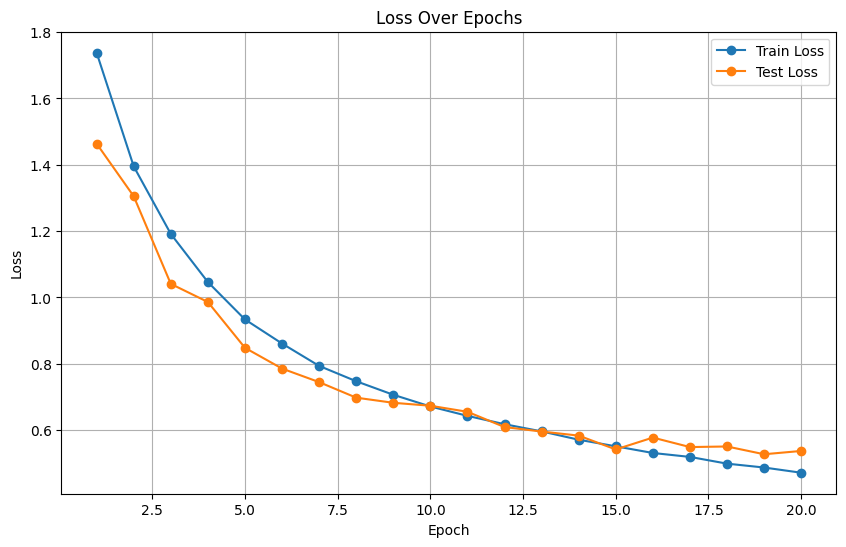

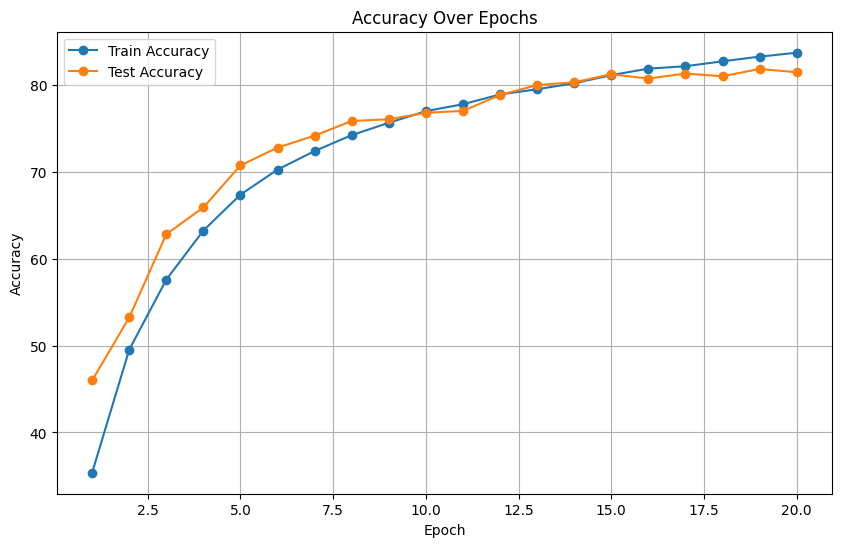

In [ ]:
GoogLeNet_train_accuracies,GoogLeNet_train_losses,GoogLeNet_test_accuracies,GoogLeNet_test_losses,total_train_time =train_and_test(GoogLeNet_model,train_loader,test_loader,GoogLeNet_criterion,GoogLeNet_optimizer,device,num_epochs=20)
plot_loss(GoogLeNet_train_losses,GoogLeNet_test_losses)
plot_accuracy(GoogLeNet_train_accuracies,GoogLeNet_test_accuracies)

#**Evaluation**

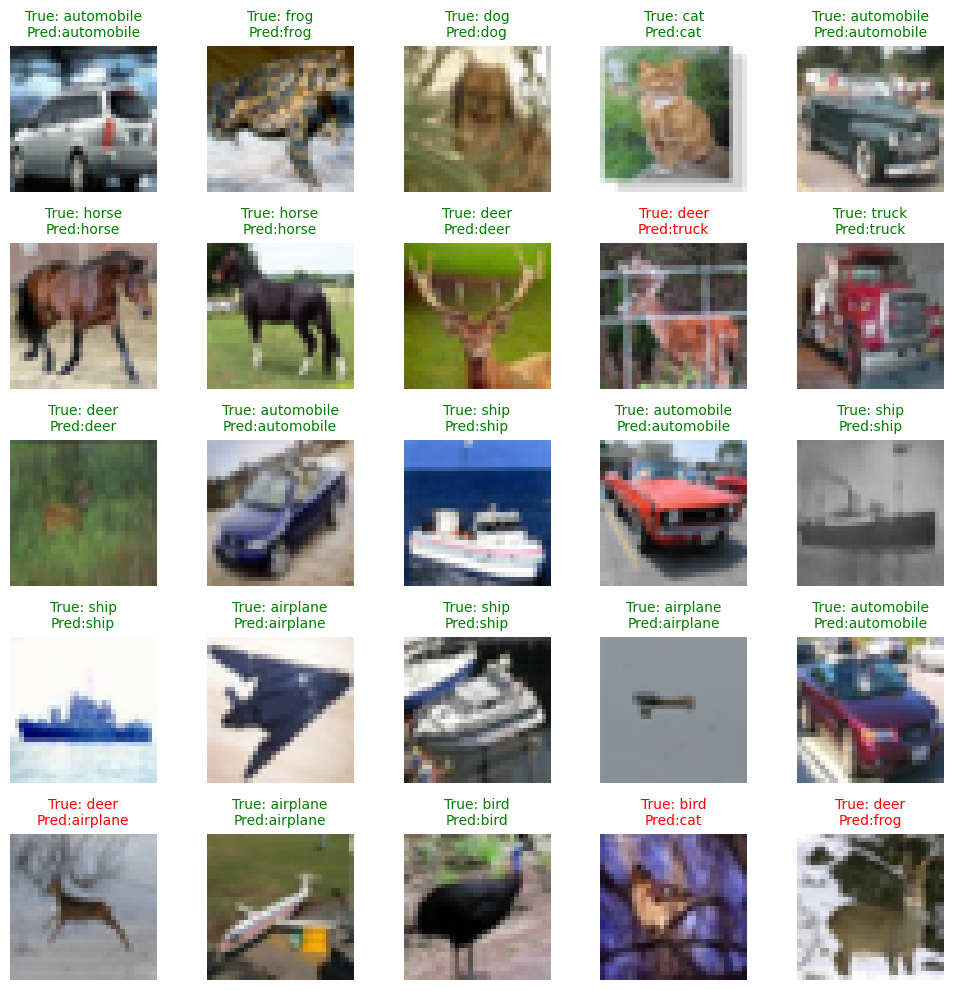

In [ ]:
visualise_predictions(GoogLeNet_model,test_loader,device,num_images=25)

**Confusion Matrix.**

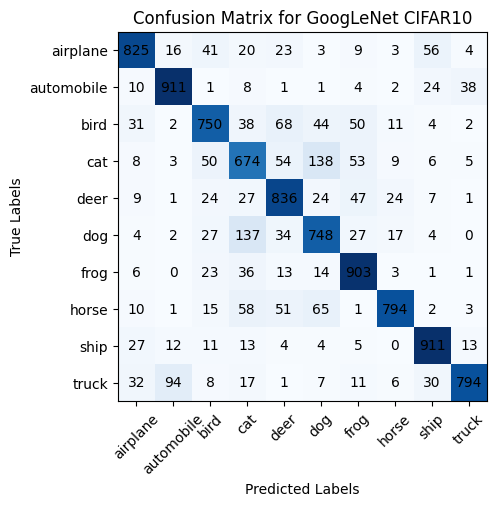

In [ ]:
GoogLeNet_model.to(device).eval()
true_labels_g =[]
pred_labels_g =[]
#Generate predictions
with torch.no_grad():
    for images,labels in test_loader:
        images,labels =images.to(device),labels.to(device)
        outputs =GoogLeNet_model(images)
        _,preds=torch.max(outputs,1)
        #true labels
        true_labels_g.extend(labels.cpu().numpy())
        #predicted labels
        pred_labels_g.extend(preds.cpu().numpy())
#Calculate the confusion matrix
cm =confusion_matrix(true_labels_g, pred_labels_g)
fig,ax =plt.subplots()
im =ax.imshow(cm,cmap=plt.cm.Blues)
#Labels for axes
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_xticks(np.arange(len(names)))
ax.set_yticks(np.arange(len(names)))
ax.set_xticklabels(names,rotation=45)
ax.set_yticklabels(names)
ax.set_title('Confusion Matrix for GoogLeNet CIFAR10')
#Text annotations
for (i,j), val in np.ndenumerate(cm):
    ax.text(j,i,f'{val}',ha='center',va='center',color='black')
plt.show()

**Classification Report.**

In [ ]:
print(f"Classification Report for GoogLeNet CIFAR10:\n"
      f"{classification_report(true_labels_g,pred_labels_g,target_names=names,digits=4)}\n")

Classification Report for GoogLeNet CIFAR10:
              precision    recall  f1-score   support

    airplane     0.8576    0.8250    0.8410      1000
  automobile     0.8743    0.9110    0.8923      1000
        bird     0.7895    0.7500    0.7692      1000
         cat     0.6556    0.6740    0.6647      1000
        deer     0.7705    0.8360    0.8019      1000
         dog     0.7137    0.7480    0.7305      1000
        frog     0.8135    0.9030    0.8559      1000
       horse     0.9137    0.7940    0.8497      1000
        ship     0.8718    0.9110    0.8910      1000
       truck     0.9222    0.7940    0.8533      1000

    accuracy                         0.8146     10000
   macro avg     0.8182    0.8146    0.8149     10000
weighted avg     0.8182    0.8146    0.8149     10000




**Save the Model**

In [ ]:
model_dir ='/content/models_CIFAR10'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    print(f"Directory 'models_CIFAR10' created at {model_dir}")
else:
    print(f"Directory 'models_CIFAR10' already exists at {model_dir}")
model_filename =f"{GoogLeNet_model.__class__.__name__}.pth"
model_path =os.path.join(model_dir, model_filename)
torch.save(GoogLeNet_model.state_dict(), model_path)
print(f'Model saved to {model_path}')

Directory 'models_CIFAR10' already exists at /content/models_CIFAR10
Model saved to /content/models_CIFAR10/GoogLeNet.pth
